<a href="https://colab.research.google.com/github/HYUNSOOLEE-6839/colab-Deep-Learning/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 영어 Word2Vec 만들기
- 영어로 된 코퍼스를 다운받아 전처리를 수행
- 전처리한 데이터를 바탕으로 Word2Vec 작업을 진행

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

### 훈련 데이터 이해하기

In [4]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7f7aef72ff50>)

### 훈련 데이터 전처리하기

In [5]:
targetXML=open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [6]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


### Word2Vec 훈련시키기

In [7]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

### 여기서 Word2Vec의 하이퍼파라미터값은 다음과 같다.
- size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
- window = 컨텍스트 윈도우 크기
- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- workers = 학습을 위한 프로세스 수
- sg = 0은 CBOW, 1은 Skip-gram.
#### . Word2Vec는 입력한 단어에 대해서 가장 유사한 단어들을 출력하는 model.wv.most_similar을 지원

In [8]:
# man과 유사한 단어 찾기
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8527241945266724), ('guy', 0.803369402885437), ('lady', 0.78069007396698), ('boy', 0.7514451146125793), ('gentleman', 0.7407535314559937), ('girl', 0.7343783378601074), ('soldier', 0.7314716577529907), ('kid', 0.676067590713501), ('poet', 0.6723096370697021), ('david', 0.6580479145050049)]


In [26]:
model.wv.most_similar(positive=['man', 'woman'], negative=['boy'], topn=3)

KeyError: ignored

### Word2Vec 모델 저장하고 로드하기

In [9]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [10]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8527241945266724), ('guy', 0.803369402885437), ('lady', 0.78069007396698), ('boy', 0.7514451146125793), ('gentleman', 0.7407535314559937), ('girl', 0.7343783378601074), ('soldier', 0.7314716577529907), ('kid', 0.676067590713501), ('poet', 0.6723096370697021), ('david', 0.6580479145050049)]


# 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [12]:
pip install konlpy

     |████████████████████████████████| 19.4MB 34.7MB/s 
     |████████████████████████████████| 92kB 10.7MB/s 
     |████████████████████████████████| 460kB 36.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [14]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f7ac8cc7210>)

In [15]:
train_data = pd.read_table('ratings.txt')

In [16]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [18]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [17]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [19]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [20]:
print(len(train_data)) # 리뷰 개수 출력

199992


In [21]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [22]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [23]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [24]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


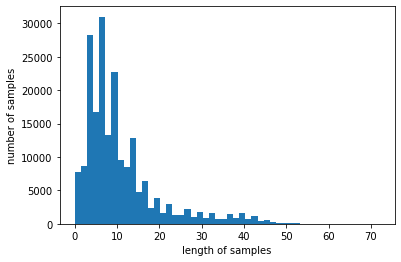

In [27]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [28]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [29]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8513674736022949), ('김수현', 0.8378806710243225), ('김명민', 0.8340967893600464), ('채민서', 0.8249303698539734), ('주진모', 0.8228285908699036), ('이민호', 0.8227858543395996), ('송강호', 0.8204261064529419), ('황정민', 0.8150339722633362), ('서영희', 0.8150277733802795), ('이준기', 0.8134247064590454)]


In [30]:
print(model.wv.most_similar("히어로"))

[('슬래셔', 0.8855990171432495), ('느와르', 0.8586885929107666), ('블록버스터', 0.8524148464202881), ('호러', 0.8454111814498901), ('무협', 0.8391672372817993), ('헐리우드', 0.8239929676055908), ('물', 0.8236279487609863), ('정통', 0.8223906755447388), ('무비', 0.8193734884262085), ('멜로', 0.8098269701004028)]
